# Intraday Flow & Vol Impact Analysis
Shawn Chen

In [1]:
!pip install yfinance


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


In [3]:
ticker = "AAPL"

df = yf.download(
    ticker,
    interval="1m",
    period="7d",
    auto_adjust=True,
    progress=False
)

df = df.dropna()
df.head()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,
2026-01-21 14:30:00+00:00,248.199997,248.750000,247.770004,248.710007,1809762
2026-01-21 14:31:00+00:00,247.960007,248.285507,247.380005,248.134995,225678
2026-01-21 14:32:00+00:00,247.199997,247.987305,247.020004,247.955002,137974
2026-01-21 14:33:00+00:00,246.690002,247.179993,246.539993,247.130005,149680
2026-01-21 14:34:00+00:00,246.990005,247.190002,246.641403,246.663406,161456


In [4]:
df["ret_1m"] = np.log(df["Close"]).diff() #returns
df["dollar_vol"] = df["Close"] * df["Volume"] #dollar volume

In [12]:
# make sure columns are flat
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df.dropna().copy()

# create minute-of-day column
df["minute"] = df.index.time

# compute seasonal volume pattern
seasonal = (
    df.groupby("minute")["Volume"]
      .agg(mean_vol="mean", std_vol="std")
      .reset_index()
)

# merge back
df = df.merge(seasonal, on="minute", how="left")

# z-score abnormal volume
df["z_vol"] = (df["Volume"] - df["mean_vol"]) / (df["std_vol"] + 1e-9)

df.head()


,Close,High,Low,Open,Volume,ret_1m,dollar_vol,minute,mean,std,z_vol,mean_vol,std_vol
0,247.960007,248.285507,247.380005,248.134995,225678,-0.000967,5.595912e+07,14:31:00,249535.142857,68482.324689,-0.348369,249535.142857,68482.324689
1,247.199997,247.987305,247.020004,247.955002,137974,-0.003070,3.410717e+07,14:32:00,181320.142857,57969.944283,-0.747735,181320.142857,57969.944283
2,246.690002,247.179993,246.539993,247.130005,149680,-0.002065,3.692456e+07,14:33:00,178924.571429,85032.059070,-0.343924,178924.571429,85032.059070
3,246.990005,247.190002,246.641403,246.663406,161456,0.001215,3.987802e+07,14:34:00,182896.285714,62607.311255,-0.342457,182896.285714,62607.311255
4,247.289993,247.410004,246.979996,246.979996,106212,0.001214,2.626516e+07,14:35:00,157570.857143,42006.984758,-1.222627,157570.857143,42006.984758


In [13]:
df["ret_1m"] = np.log(df["Close"]).diff() #returns

In [14]:
# flow imbalance --> buyer / seller pressure
df["sign"] = np.sign(df["ret_1m"])
df["sign"] = df["sign"].replace(0, method="ffill")

df["signed_vol"] = df["sign"] * df["Volume"]

df["ofi_5m"] = df["signed_vol"].rolling(5).sum()
df["ofi_norm"] = df["ofi_5m"] / (df["Volume"].rolling(5).sum() + 1)


/tmp/ipython-input-3704263022.py:3: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df["sign"] = df["sign"].replace(0, method="ffill")


In [15]:
# realized volatility
df["rv_5m"] = df["ret_1m"].rolling(5).std()
# liquidity proxy (Amihud)
df["dollar_vol"] = df["Close"] * df["Volume"]
df["illiq"] = abs(df["ret_1m"]) / (df["dollar_vol"] + 1)


In [24]:
# define extreme flow events
events = df[
    (df["z_vol"] > 1.5) &
    (abs(df["ofi_norm"]) > 0.65)
].copy()

len(events)

events[["z_vol", "ofi_norm"]].head()


,z_vol,ofi_norm
112,1.679322,-0.732281
125,2.109355,-0.999997
126,1.719624,-0.999997
130,2.086058,-0.999997
144,2.090035,-0.666140


In [25]:
# forward impact
horizons = [1, 5, 15]

for h in horizons:
    df[f"fwd_ret_{h}m"] = df["Close"].shift(-h) / df["Close"] - 1
    df[f"fwd_vol_{h}m"] = df["ret_1m"].rolling(h).std().shift(-h)

event_data = df.loc[events.index]




In [26]:
# momentum vs mean reversion
buy_events = event_data[event_data["ofi_norm"] > 0]
sell_events = event_data[event_data["ofi_norm"] < 0]

buy_events[[f"fwd_ret_{h}m" for h in horizons]].mean()
sell_events[[f"fwd_ret_{h}m" for h in horizons]].mean()



,0
fwd_ret_1m,0.000032
fwd_ret_5m,0.000098
fwd_ret_15m,-0.000746


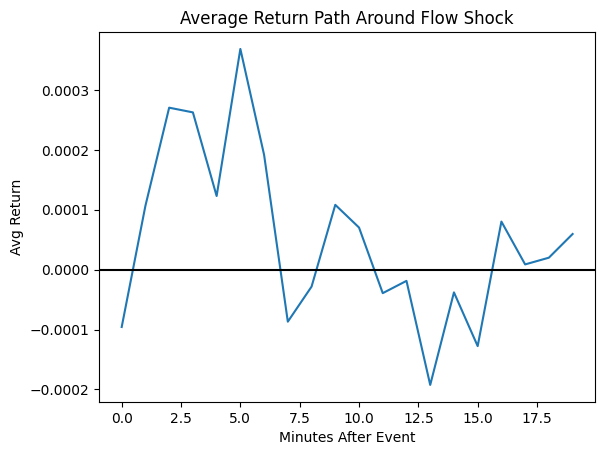

In [27]:
avg_path = []

for i in range(-5, 15):
    avg_path.append(df["ret_1m"].shift(-i).loc[events.index].mean())

plt.plot(avg_path)
plt.axhline(0, color="black")
plt.title("Average Return Path Around Flow Shock")
plt.xlabel("Minutes After Event")
plt.ylabel("Avg Return")
plt.show()
